In [6]:
from datasets import MultiTaskDataset
from alg.coreset import Coreset
from alg.vcl_net import Initialization, MultiHeadVCLSplitMNIST, MultiHeadVCLSplitNotMNIST
import seaborn as sns
import pandas as pd
import torch
from torch import nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [7]:
from typing import Union, Literal

def train_MLE(model, _train_x, _train_y, task_i, n_epochs, batch_size, verbose):
    def get_accuracy(model, x, y, task_i, batch_size):
        pred_y = []
        with torch.no_grad():
            for batch in range(int(np.ceil(x.shape[0] / batch_size))):
                batch_idx0 = batch * batch_size
                batch_idx1 = batch * batch_size + batch_size
                logits = nn.Softmax(-1)(model.predict_MLE(x[batch_idx0:batch_idx1], task_i))
                pred_y.append(logits.argmax(-1))
            pred_y = torch.cat(pred_y)
            acc = (pred_y == y).cpu().numpy().mean()
        return acc

    current_opt = torch.optim.Adam(model.parameters(), lr=0.01)
    num_datapoints = _train_x.shape[0]
    train_x, train_y, val_x, val_y = _train_x[:int(num_datapoints*0.8)].clone(), _train_y[:int(num_datapoints*0.8)].clone(), _train_x[int(num_datapoints*0.8):].clone(), _train_y[int(num_datapoints*0.8):].clone()
    best_val_loss = None
    best_locs = None
    for epoch in (tqdm if verbose else iter)(range(n_epochs)):
        model.train()
        ELBO_batch = []
        for batch in range(int(np.ceil(train_x.shape[0] / batch_size))):
            batch_idx0 = batch * batch_size
            batch_idx1 = batch * batch_size + batch_size
            current_opt.zero_grad()
            loss = model.MLE_loss(x=train_x[batch_idx0: batch_idx1], 
                                                y=train_y[batch_idx0: batch_idx1], 
                                                task_i_mask=task_i)
            nn.utils.clip_grad_value_(model.parameters(), 5)
            loss.backward()
            current_opt.step()
        model.eval()
        with torch.no_grad():
            val_loss = model.MLE_loss(x=val_x, y=val_y, task_i_mask=task_i)
            if best_val_loss is None or val_loss < best_val_loss:
                best_val_loss = val_loss
                # print(val_loss)
                locs, _ = model.get_params()
                best_locs = locs
        
    locs, vars = model.get_params()
    with torch.no_grad():
        model.set_params(best_locs, vars)

    if verbose:
        print(f"Validation accuracy on MLE model: {get_accuracy(model, val_x, val_y, task_i, 1000000)}")
    model.train()
    return model

def run(
        model_name: str,
        dataset: Literal['split MNIST', 'split notMNIST'], 
        first_init: Initialization = Initialization.RANDOM, 
        subsequent_head_init: Initialization = Initialization.RANDOM, 
        shared_net_init: Union[Initialization, None] = None, 
        n_epochs=120, 
        batch_size=256, 
        coreset_size=40, 
        coreset_method='random', 
        coreset_post_process_method=None,
        verbose=False
    ):
    if dataset == 'split MNIST':
        model_cls = MultiHeadVCLSplitMNIST
    elif dataset == 'split notMNIST':
        model_cls = MultiHeadVCLSplitNotMNIST
    else:
        raise Exception(f"Invalid dataset: {dataset}")
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    test_x_all = []
    test_y_all = []
    test_task_i_all = []

    coreset = Coreset(method=coreset_method, post_process_method=coreset_post_process_method, task_coreset_size=coreset_size)
    dataset = MultiTaskDataset(dataset, device)
    accuracies = []

    previous_model, pred_model = None, None
    for task_i in range(5):
        train_x, train_y, test_x, test_y = dataset.get_task_dataset(task_i)
        test_x_all.append(test_x)
        test_y_all.append(test_y)
        test_task_i_all.append(torch.ones((test_x.shape[0]), dtype=int) * task_i)

        train_x, train_y = coreset.update(train_x, train_y, task_i)
        coreset.post_process(task_i, pred_model.shared if pred_model is not None else None)

        # define current model
        if task_i == 0:
            if first_init is Initialization.CUSTOM:
                pretrained_model = train_MLE(model_cls(num_heads=1, initialization=Initialization.RANDOM).to(device), train_x, train_y, 0, 100, 500, verbose)
                current_model = model_cls(num_heads=1, initialization=Initialization.CUSTOM, custom_init=pretrained_model).to(device)
            else:
                assert isinstance(first_init, Initialization)
                current_model = model_cls(num_heads=1, initialization=first_init).to(device)
            current_model.set_prior(model_cls(num_heads=1, initialization=Initialization.DEFAULT).to(device))
        else:
            current_model = model_cls.new_from_prior(previous_model)
            current_model.add_head(initialization=subsequent_head_init)
            if shared_net_init is not None:
                assert isinstance(shared_net_init, Initialization)
                current_model.init_shared_weights(shared_net_init)

        assert len(current_model.heads) == task_i + 1
        current_opt = torch.optim.Adam(current_model.parameters(), lr=0.001)

        ELBO = []
        for epoch in (tqdm if verbose else iter)(range(n_epochs)):
            ELBO_batch = []
            for batch in range(int(np.ceil(train_x.shape[0] / batch_size))):
                batch_idx0 = batch * batch_size
                batch_idx1 = batch * batch_size + batch_size
                current_opt.zero_grad()
                elbo = current_model.calculate_ELBO(x=train_x[batch_idx0: batch_idx1], 
                                                    y=train_y[batch_idx0: batch_idx1], 
                                                    n_particles=1,
                                                    task_i_mask=task_i,
                                                    dataset_size=train_x.shape[0])
                elbo.backward()
                nn.utils.clip_grad_value_(current_model.parameters(), 5)
                current_opt.step()
                ELBO_batch.append(elbo.item())
            ELBO.append(np.mean(ELBO_batch))
        if verbose:
            plt.plot(ELBO)
            plt.yscale("log")
            plt.show()

        test_x_tensor = torch.cat(test_x_all)
        test_y_tensor = torch.cat(test_y_all)
        test_task_i_mask_tensor = torch.cat(test_task_i_all)
        assert set([k.item() for k in test_task_i_mask_tensor.unique()]) == set([i for i in range(task_i + 1)]), f"{set([k.item() for k in test_task_i_mask_tensor.unique()])} != {set([i for i in range(task_i + 1)])} Invalid, {test_task_i_mask_tensor.unique()}"
        pred_y = []
        with torch.no_grad():
            for batch in range(int(np.ceil(test_x_tensor.shape[0] / batch_size))):
                batch_idx0 = batch * batch_size
                batch_idx1 = batch * batch_size + batch_size
                pred_logit_samples = nn.Softmax(-1)(torch.stack(current_model.predict(test_x_tensor[batch_idx0:batch_idx1], test_task_i_mask_tensor[batch_idx0:batch_idx1], 100), 0)).mean(0)
                pred_y.append(pred_logit_samples.argmax(-1))
            pred_y = torch.cat(pred_y)
            acc = (pred_y == test_y_tensor).cpu().numpy().mean()
        if verbose:
            print("Accuracy by the propagation model is %.4f"%acc)


        # calculate prediction model
        pred_model = model_cls.new_from_prior(current_model)
        pred_opt = torch.optim.Adam(pred_model.parameters(), lr=0.001)

        ELBO = []
        for epoch in (tqdm if verbose else iter)(range(n_epochs)):
            ELBO_batch = []
            for batch in range(int(np.ceil(coreset.x[coreset.mult_mask].shape[0] / batch_size))):
                batch_idx0 = batch * batch_size
                batch_idx1 = batch * batch_size + batch_size
                pred_opt.zero_grad()
                elbo = pred_model.calculate_ELBO(x=coreset.x[coreset.mult_mask][batch_idx0: batch_idx1], 
                                                y=coreset.y[coreset.mult_mask][batch_idx0: batch_idx1], 
                                                task_i_mask=coreset.task_mask[coreset.mult_mask][batch_idx0: batch_idx1],
                                                n_particles=1,
                                                dataset_size=coreset.x[coreset.mult_mask].shape[0])
                elbo.backward()
                nn.utils.clip_grad_value_(pred_model.parameters(), 5)
                pred_opt.step()
                ELBO_batch.append(elbo.item())
            ELBO.append(np.mean(ELBO_batch))
        if verbose:
            plt.plot(ELBO)
            plt.show()

        test_x_tensor = torch.cat(test_x_all)
        test_y_tensor = torch.cat(test_y_all)
        test_task_i_mask_tensor = torch.cat(test_task_i_all)
        pred_y = []
        with torch.no_grad():
            for batch in range(int(np.ceil(test_x_tensor.shape[0] / batch_size))):
                batch_idx0 = batch * batch_size
                batch_idx1 = batch * batch_size + batch_size
                pred_logit_samples = nn.Softmax(-1)(torch.stack(pred_model.predict(test_x_tensor[batch_idx0:batch_idx1], test_task_i_mask_tensor[batch_idx0:batch_idx1], 100), 0)).mean(0)
                pred_y.append(pred_logit_samples.argmax(-1))
            pred_y = torch.cat(pred_y)
            acc = (pred_y == test_y_tensor).cpu().numpy().mean()
        accuracies.append((acc, task_i, model_name))
        if verbose:
            print("Task {:d}, Accuracy: {:.4f}".format(task_i, acc))
        previous_model = current_model
    return accuracies

In [8]:
def update_results(results_df, results_list):
    df_temp = pd.DataFrame(results_list, columns=["Accuracy", "Task Index", "Model"])
    return pd.concat([results_df, df_temp], ignore_index=True, axis=0)

# Coreset tests

In [4]:
CORESET_RESULTS = pd.DataFrame(columns=["Accuracy", "Task Index", "Model"])

In [14]:
for i in range(10):
    results = run('VAA+K', 'split notMNIST', first_init=Initialization.RANDOM, subsequent_head_init=Initialization.RANDOM, shared_net_init=None, batch_size=1024, coreset_method='vaa-k-center')
    CORESET_RESULTS = update_results(CORESET_RESULTS, results)

In [15]:
for i in range(10):
    results = run('K', 'split notMNIST', first_init=Initialization.RANDOM, subsequent_head_init=Initialization.RANDOM, shared_net_init=None, batch_size=1024, coreset_method='k-center')
    CORESET_RESULTS = update_results(CORESET_RESULTS, results)

In [ ]:
for i in range(10):
    results = run('R', 'split notMNIST', first_init=Initialization.RANDOM, subsequent_head_init=Initialization.RANDOM, shared_net_init=None, batch_size=1024, coreset_method='random')
    CORESET_RESULTS = update_results(CORESET_RESULTS, results)

In [ ]:
for i in range(10):
    results = run('R+M', 'split notMNIST', first_init=Initialization.RANDOM, subsequent_head_init=Initialization.RANDOM, shared_net_init=None, batch_size=1024, coreset_method='random', coreset_post_process_method='shared-emb-mult')
    CORESET_RESULTS = update_results(CORESET_RESULTS, results)

In [ ]:
for i in range(10):
    results = run('VAA+K+M', 'split notMNIST', first_init=Initialization.RANDOM, subsequent_head_init=Initialization.RANDOM, shared_net_init=None, batch_size=1024, coreset_method='vaa-k-center', coreset_post_process_method='shared-emb-mult')
    CORESET_RESULTS = update_results(CORESET_RESULTS, results)

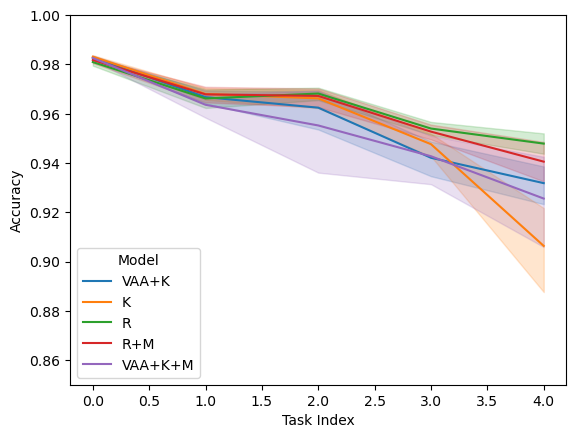

In [17]:
p = sns.lineplot(x="Task Index", y="Accuracy", hue="Model", data=CORESET_RESULTS)
p.set(ylim=(0.85, 1));

In [23]:
CORESET_RESULTS_EXTRA_SMALL = pd.DataFrame(columns=["Accuracy", "Task Index", "Model"])

In [26]:
for i in range(15):
    results = run('VAA+K', 'split notMNIST', first_init=Initialization.RANDOM, subsequent_head_init=Initialization.RANDOM, shared_net_init=None, batch_size=1024, coreset_method='vaa-k-center', coreset_size=4)
    CORESET_RESULTS_EXTRA_SMALL = update_results(CORESET_RESULTS_EXTRA_SMALL, results)
for i in range(15):
    results = run('K', 'split notMNIST', first_init=Initialization.RANDOM, subsequent_head_init=Initialization.RANDOM, shared_net_init=None, batch_size=1024, coreset_method='k-center', coreset_size=4)
    CORESET_RESULTS_EXTRA_SMALL = update_results(CORESET_RESULTS_EXTRA_SMALL, results)
for i in range(15):
    results = run('R', 'split notMNIST', first_init=Initialization.RANDOM, subsequent_head_init=Initialization.RANDOM, shared_net_init=None, batch_size=1024, coreset_method='random', coreset_size=4)
    CORESET_RESULTS_EXTRA_SMALL = update_results(CORESET_RESULTS_EXTRA_SMALL, results)
# for i in range(10):
#     results = run('R+M', 'split notMNIST', first_init=Initialization.RANDOM, subsequent_head_init=Initialization.RANDOM, shared_net_init=None, batch_size=1024, coreset_method='random', coreset_post_process_method='shared-emb-mult', coreset_size=8)
#     CORESET_RESULTS_EXTRA_SMALL = update_results(CORESET_RESULTS_EXTRA_SMALL, results)
# for i in range(10):
#     results = run('VAA+K+M', 'split notMNIST', first_init=Initialization.RANDOM, subsequent_head_init=Initialization.RANDOM, shared_net_init=None, batch_size=1024, coreset_method='vaa-k-center', coreset_post_process_method='shared-emb-mult', coreset_size=8)
#     CORESET_RESULTS_EXTRA_SMALL = update_results(CORESET_RESULTS_EXTRA_SMALL, results)

VAA+K	0.948
K	0.947
R	0.945


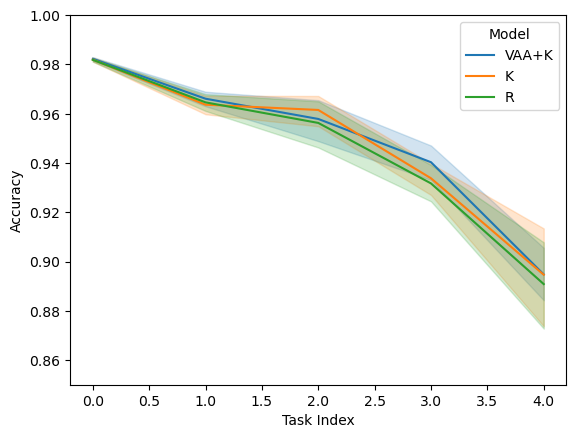

In [36]:
p = sns.lineplot(x="Task Index", y="Accuracy", hue="Model", data=CORESET_RESULTS_EXTRA_SMALL)
p.set(ylim=(0.85, 1));

for model in CORESET_RESULTS_EXTRA_SMALL['Model'].unique():
    print(f"{model}\t{CORESET_RESULTS_EXTRA_SMALL.loc[CORESET_RESULTS_EXTRA_SMALL['Model'] == model]['Accuracy'].mean():.3f}")


In [15]:
CORESET_RESULTS_SMALL = pd.DataFrame(columns=["Accuracy", "Task Index", "Model"])

In [16]:
for i in range(50):
    results = run('VAA+K', 'split notMNIST', first_init=Initialization.RANDOM, subsequent_head_init=Initialization.RANDOM, shared_net_init=None, batch_size=1024, coreset_method='vaa-k-center', coreset_size=10)
    CORESET_RESULTS_SMALL = update_results(CORESET_RESULTS_SMALL, results)
for i in range(50):
    results = run('K', 'split notMNIST', first_init=Initialization.RANDOM, subsequent_head_init=Initialization.RANDOM, shared_net_init=None, batch_size=1024, coreset_method='k-center', coreset_size=10)
    CORESET_RESULTS_SMALL = update_results(CORESET_RESULTS_SMALL, results)
for i in range(50):
    results = run('R', 'split notMNIST', first_init=Initialization.RANDOM, subsequent_head_init=Initialization.RANDOM, shared_net_init=None, batch_size=1024, coreset_method='random', coreset_size=10)
    CORESET_RESULTS_SMALL = update_results(CORESET_RESULTS_SMALL, results)
# for i in range(10):
#     results = run('R+M', 'split notMNIST', first_init=Initialization.RANDOM, subsequent_head_init=Initialization.RANDOM, shared_net_init=None, batch_size=1024, coreset_method='random', coreset_post_process_method='shared-emb-mult', coreset_size=8)
#     CORESET_RESULTS_SMALL = update_results(CORESET_RESULTS_SMALL, results)
# for i in range(10):
#     results = run('VAA+K+M', 'split notMNIST', first_init=Initialization.RANDOM, subsequent_head_init=Initialization.RANDOM, shared_net_init=None, batch_size=1024, coreset_method='vaa-k-center', coreset_post_process_method='shared-emb-mult', coreset_size=8)
#     CORESET_RESULTS_SMALL = update_results(CORESET_RESULTS_SMALL, results)

VAA+K	0.949
K	0.944
R	0.952


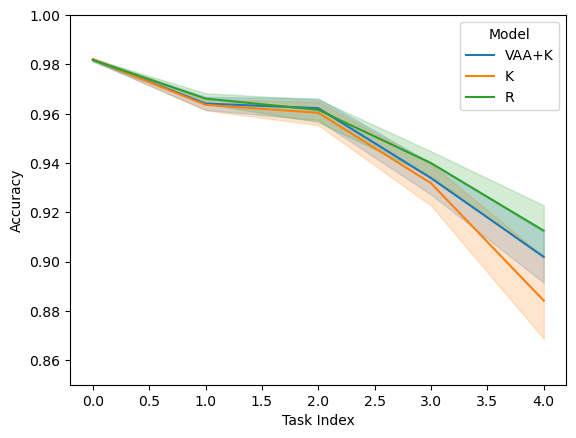

In [17]:
p = sns.lineplot(x="Task Index", y="Accuracy", hue="Model", data=CORESET_RESULTS_SMALL)
p.set(ylim=(0.85, 1));

for model in CORESET_RESULTS_SMALL['Model'].unique():
    print(f"{model}\t{CORESET_RESULTS_SMALL.loc[CORESET_RESULTS_SMALL['Model'] == model]['Accuracy'].mean():.3f}")
